# Visulization of TAT
## Load Model

In [1]:
import argparse
import torch
from config import cfg
from datasets import make_dataloader
from model import make_model

## Visualize Templates

In [ ]:
config_file = "configs/Market/vit_tatot_stride_384.yml"
opts = ["MODEL.DIST_TRAIN", False]
weight = "/home/zhaozr/code/logs/market_vit_tatot_stride_384/transformer_120.pth"

if config_file != "":
    cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
cfg.freeze()

(
    train_loader,
    train_loader_normal,
    val_loader,
    num_query,
    num_classes,
    camera_num,
    view_num,
) = make_dataloader(cfg)

model = make_model(
    cfg, num_class=num_classes, camera_num=camera_num, view_num=view_num
)

model.load_param(weight)

In [ ]:
templates = model.base.templates.detach()
templates.shape

In [ ]:
import torchvision.transforms as T
from utils.commom_tools import transform_invert

train_transforms = T.Compose([
    T.Resize([384, 128], interpolation=3),
    T.RandomHorizontalFlip(p=0.5),
    T.Pad(10),
    T.RandomCrop([384, 128]),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.02, 0.02, 0.02]),
    # RandomErasing(probability=cfg.INPUT.RE_PROB, mode='pixel', max_count=1, device='cpu')
])
imgs = [transform_invert(templates[i], train_transforms) for i in range(len(templates))]

In [ ]:
templates[0][0].std()

tensor(0.0004)

In [ ]:
import numpy as np
from PIL import Image

for t in templates:
    tmin = t.min()
    tmax = t.max()
    t = (t - tmin) / (tmax - tmin) * 256
    t = t.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    t = np.array(t) * 255
    t = Image.fromarray(t.astype("uint8")).convert("RGB")
    t.show()

## Visualizer for Attention

Ref: https://github.com/luo3300612/Visualizer

### Model Preparation

In [5]:
def get_model(config_file, weight_file):
    if config_file != "":
        cfg.merge_from_file(config_file)
    opts = ["MODEL.DIST_TRAIN", False]
    cfg.merge_from_list(opts)
    cfg.freeze()

    (
        train_loader,
        train_loader_normal,
        val_loader,
        num_query,
        num_classes,
        camera_num,
        view_num,
    ) = make_dataloader(cfg)

    model = make_model(
        cfg, num_class=num_classes, camera_num=camera_num, view_num=view_num
    )
    model.load_param(weight_file)
    model.eval()
    return model

In [6]:
import torchvision.transforms as T
from PIL import Image
from utils.commom_tools import get_attention_map, plot_attention_map, get_template_attention_map

transform = T.Compose([
    T.Resize([384, 128], interpolation=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
transform256 = T.Compose([
    T.Resize([256, 128], interpolation=3),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    

def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]
    
    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    padded_image, padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]
        
    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')
    

def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    
def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

In [8]:
def visualize_grid_to_grid_with_template(att_map, grid_index, image, grid_size=14, alpha=0.6, cmap='rainbow'):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    att_map = att_map[:, 1:]
    pixel = grid_size[0] * grid_size[1]
    
    imgatt = att_map[:pixel + 1, :pixel]
    tmpltatt = np.concatenate([att_map[:1, :pixel], att_map[pixel:, :pixel]], axis=0)

    H,W = imgatt.shape
    with_cls_token = False
    
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = imgatt[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    mask_tmplt = tmpltatt[grid_index].reshape(grid_size[0], grid_size[1])
    mask_tmplt = Image.fromarray(mask_tmplt).resize((image.size))
    
    fig, ax = plt.subplots(1, 3, figsize=(4,3))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap=cmap)
    ax[1].axis('off')
    
    ax[2].imshow(grid_image)
    ax[2].imshow(mask_tmplt/np.max(mask_tmplt), alpha=alpha, cmap=cmap)
    ax[2].axis('off')
    
    plt.show()
    
def visualize_grid_to_grid_mean_with_template(att_map, image, grid_size=14, alpha=0.6, cmap='rainbow'):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    att_map = att_map[:, 1:]
    pixel = grid_size[0] * grid_size[1]
    
    imgatt = att_map[:pixel + 1, :pixel].mean(axis=0)
    tmpltatt = np.concatenate([att_map[:1, :pixel], att_map[pixel:, :pixel]], axis=0).mean(axis=0)

    with_cls_token = False
    
    mask = imgatt.reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    mask_tmplt = tmpltatt.reshape(grid_size[0], grid_size[1])
    mask_tmplt = Image.fromarray(mask_tmplt).resize((image.size))
    
    fig, ax = plt.subplots(1, 3, figsize=(4,3))
    fig.tight_layout()
    
    ax[0].imshow(image)
    ax[0].axis('off')
    
    ax[1].imshow(image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap=cmap)
    ax[1].axis('off')
    
    ax[2].imshow(image)
    ax[2].imshow(mask_tmplt/np.max(mask_tmplt), alpha=alpha, cmap=cmap)
    ax[2].axis('off')
    
    plt.show()

In [9]:
class Visualizer:
    def __init__(self, grid_size=14, alpha=0.6, cmap='jet') -> None:
        self.grid_size = grid_size if isinstance(grid_size, tuple) else (grid_size, grid_size)
        self.alpha = alpha
        self.cmap = cmap
        self.alpha = alpha
        self.cmap = cmap
        
        self.pixel = self.grid_size[0] * self.grid_size[1]
        
    def _get_self_mat(self, att):
        return att[:self.pixel + 1, 1:self.pixel + 1].mean(axis=0)
    
    def _get_side_mat(self, att):
        return np.concatenate([att[:1, 1:self.pixel + 1], att[self.pixel:, 1:self.pixel + 1]], axis=0).mean(axis=0)
        
    def _get_mask(self, att, size):
        mask = att.reshape(self.grid_size[0], self.grid_size[1])
        return Image.fromarray(mask).resize((size))
    
    def _show_line(self, image, masks, figsize=(4,3)):
        fig, ax = plt.subplots(1, len(masks) + 1, figsize=figsize)
        fig.tight_layout()
        
        ax[0].imshow(image)
        ax[0].axis('off')
        for i in range(0, len(masks)):
            ax[i + 1].imshow(image)
            ax[i + 1].imshow(masks[i]/np.max(masks[i]), alpha=self.alpha, cmap=self.cmap)
            ax[i + 1].axis('off')
        fig.tight_layout()
        plt.show()
    
    def v_mean_with_temp(self, att_map, image):
        imgatt = self._get_self_mat(att_map)
        tmpltatt = self._get_side_mat(att_map)
        mask = self._get_mask(imgatt, image.size)
        mask_tmplt = self._get_mask(tmpltatt, image.size)
        self._show_line(image, [mask, mask_tmplt], figsize=(4,3))
        
    def v_list_self(self, att_maps, image, figsize=(4,3)):
        """Generate self attention on TAT."""
        atts = [self._get_self_mat(att_map) for att_map in att_maps]
        masks = [self._get_mask(att, image.size) for att in atts]
        self._show_line(image, masks, figsize=figsize)
        
    def v_list_side(self, att_maps, image, figsize=(4,3)):
        """Generate side attention on TAT."""
        atts = [self._get_side_mat(att_map) for att_map in att_maps]
        masks = [self._get_mask(att, image.size) for att in atts]
        self._show_line(image, masks, figsize=figsize)
        
v = Visualizer(grid_size=(31, 10))

### Visualize Attention

In [10]:
def inference(imgpath, model, transform, camlabel):
    img = Image.open(imgpath)
    out, att_mat = model(transform(img).unsqueeze(0), cam_label=[camlabel - 1], get_attn_weights=True)
    att_mat = [a.detach().cpu().numpy() for a in att_mat]
    return img, att_mat

def let_me_see_see(img, att_mat, grid_size=(31, 10), layers=[1, 3, 6, 10]):
    v = Visualizer(grid_size=grid_size)
    print("Mean Self Attention")
    v.v_list_self([att_mat[layer][0].mean(axis=0) for layer in layers], img, figsize=(6,3))
    print("Mean Side Attention")
    v.v_list_side([att_mat[layer][0].mean(axis=0) for layer in layers], img, figsize=(6,3))

#### Market

##### All

=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
using Transformer_type: vit_base_patch16_224_TATOT as a backbone
using stride: [12, 12], and patch number is num_y31 * num_x10
camera number is : 6
using SIE_Lambda is : 3.0
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1
templates shape:  (6, 3, 384, 128)
Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 621, 768]) with height:31 width: 10
Loading pretrained ImageNet model......from /home/zhaozr/.cache/torch/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth
using shuffle_groups size:2
using shift_num size:5
using divide_length size:4
===========building transformer with JPM mod

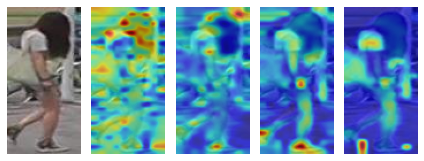

Mean Side Attention


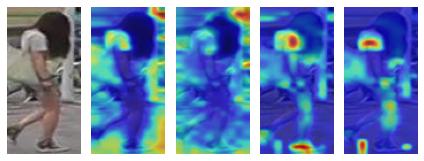

Mean Self Attention


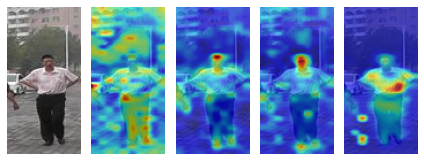

Mean Side Attention


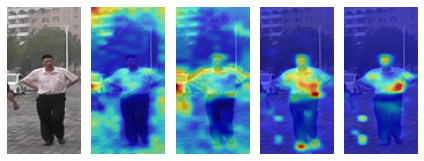

Mean Self Attention


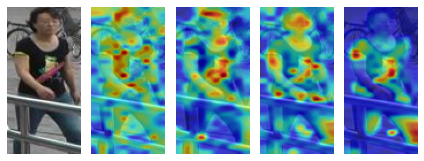

Mean Side Attention


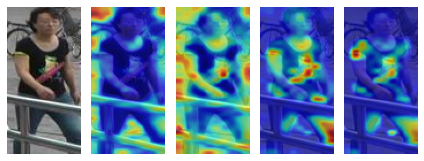

Mean Self Attention


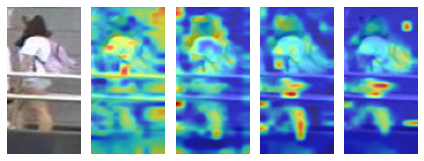

Mean Side Attention


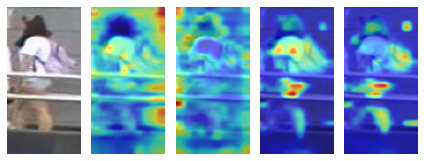

Mean Self Attention


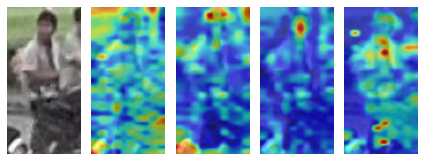

Mean Side Attention


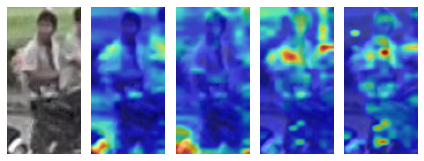

Mean Self Attention


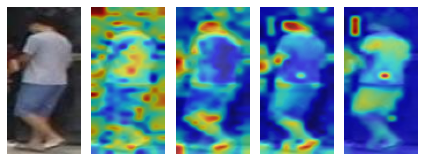

Mean Side Attention


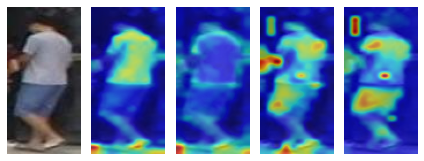

Mean Self Attention


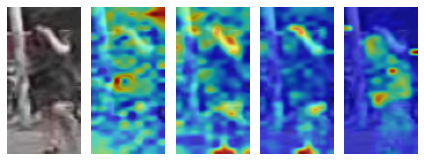

Mean Side Attention


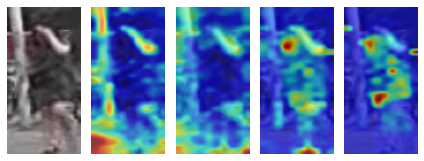

In [15]:
model = get_model("configs/Market/vit_tatot_stride_384.yml", "/home/zhaozr/code/logs/market_vit_tatot_stride_384/transformer_120.pth")

images = [("../../data/market1501/bounding_box_test/0784_c4s4_020510_01.jpg", 4),
          ("../../data/market1501/bounding_box_test/0092_c1s1_014776_04.jpg", 1),
          ("../../data/market1501/bounding_box_test/0165_c2s1_029676_03.jpg", 2),
          ("../../data/market1501/query/0194_c6s1_038276_00.jpg", 6),
          ("../../data/market1501/query/0124_c3s1_020576_00.jpg", 3),
          ("../../data/market1501/query/1457_c6s3_082067_00.jpg", 6),
          ("../../data/market1501/query/0096_c5s1_015776_00.jpg", 5),
]

for (path, cam) in images:
    img, att = inference(path, model, transform, camlabel=cam)
    let_me_see_see(img, att, grid_size=(31, 10), layers=[1, 3, 6, 10])

##### Temple

In [47]:
img = Image.open("../../data/market1501/bounding_box_test/0784_c4s4_020510_01.jpg")
out, att_mat = model(transform(img).unsqueeze(0), cam_label=[3], get_attn_weights=True)
att_mat = [a.detach().cpu().numpy() for a in att_mat]
len(att_mat), att_mat[0].shape

(11, (1, 12, 621, 621))

Mean Self Attention


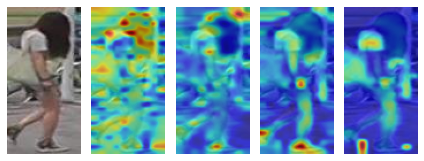

Mean Side Attention


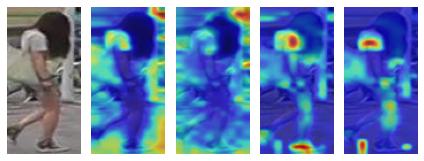

In [58]:
v = Visualizer(grid_size=(31, 10))
print("Mean Self Attention")
v.v_list_self([att_mat[layer][0].mean(axis=0) for layer in [1, 3, 6, 10]], img, figsize=(6,3))
print("Mean Side Attention")
v.v_list_side([att_mat[layer][0].mean(axis=0) for layer in [1, 3, 6, 10]], img, figsize=(6,3))

In [ ]:
layer = 1
head = 5
grid_index = 115
# single head, single grid
# visualize_grid_to_grid_with_template(att_mat[layer][0,head,:,:], grid_index, img, grid_size=(31, 10))
# mean head, single grid
# visualize_grid_to_grid_with_template(att_mat[layer][0].mean(axis=0), grid_index, img, grid_size=(31, 10))
# mean head, mean grid
for layer in range(len(att_mat)):
    visualize_grid_to_grid_mean_with_template(att_mat[layer][0].mean(axis=0), img, grid_size=(31, 10), alpha=0.6, cmap='jet')

##### Person 2

In [ ]:
img = Image.open("../../data/market1501/query/0342_c6s1_079301_00.jpg")
out, att_mat = model(transform(img).unsqueeze(0), cam_label=[5], get_attn_weights=True)
att_mat = [a.detach().cpu().numpy() for a in att_mat]
for layer in range(len(att_mat)):
    visualize_grid_to_grid_mean_with_template(att_mat[layer][0].mean(axis=0), img, grid_size=(31, 10), alpha=0.6, cmap='jet')

##### Person 3

In [ ]:
img = Image.open("../../data/market1501/query/0483_c2s3_075127_00.jpg")
out, att_mat = model(transform(img).unsqueeze(0), cam_label=[1], get_attn_weights=True)
att_mat = [a.detach().cpu().numpy() for a in att_mat]
for layer in range(len(att_mat)):
    visualize_grid_to_grid_mean_with_template(att_mat[layer][0].mean(axis=0), img, grid_size=(31, 10))

#### Occluded Duke

This dataset has been downloaded.
{0, 1, 2, 3, 4, 5, 6, 7} cam_container
{0, 1, 2, 3, 4, 5, 6, 7} cam_container
{0, 1, 2, 3, 4, 5, 6, 7} cam_container
=> DukeMTMC-reID loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   702 |    15618 |         8
  query    |   519 |     2210 |         8
  gallery  |  1110 |    17661 |         8
  ----------------------------------------
using Transformer_type: vit_base_patch16_224_TAT as a backbone
using stride: [11, 11], and patch number is num_y22 * num_x11
camera number is : 8
using SIE_Lambda is : 3.0
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1
templates shape:  (8, 242, 768)
Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 485, 768]) with height:22 width: 11
Loading pretrained ImageNet model......from /home/zhaozr/.cache/torch/checkpoints/jx_vit

/home/zhaozr/.miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


using shuffle_groups size:2
using shift_num size:5
using divide_length size:4
===========building transformer with JPM module ===========
Loading pretrained model from /home/zhaozr/code/logs/occ_duke_vit_tat_stride/transformer_120.pth
Mean Self Attention


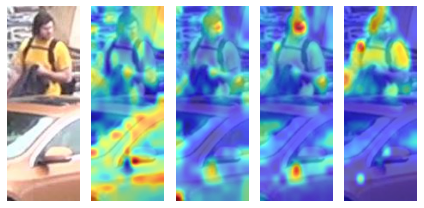

Mean Side Attention


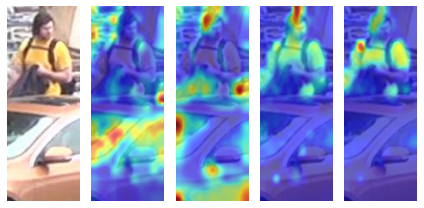

Mean Self Attention


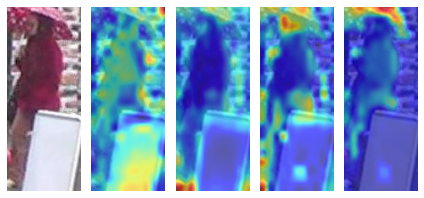

Mean Side Attention


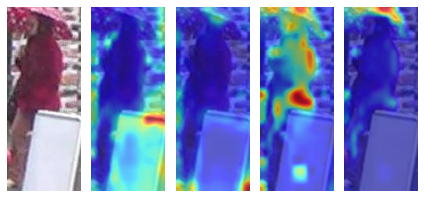

Mean Self Attention


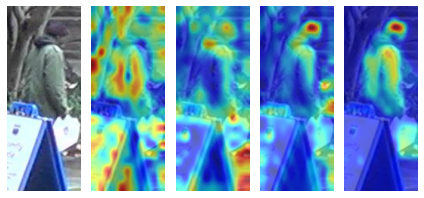

Mean Side Attention


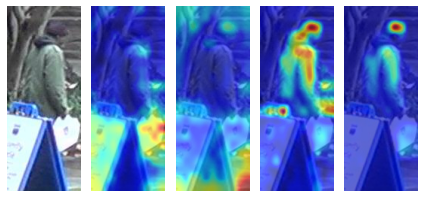

Mean Self Attention


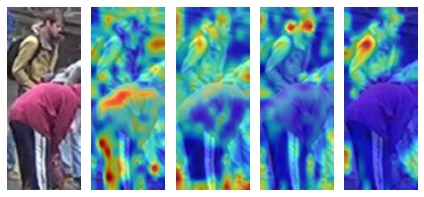

Mean Side Attention


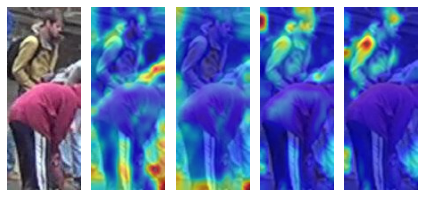

Mean Self Attention


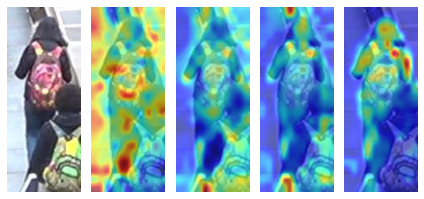

Mean Side Attention


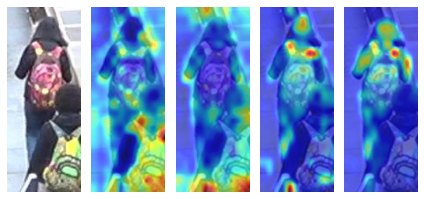

Mean Self Attention


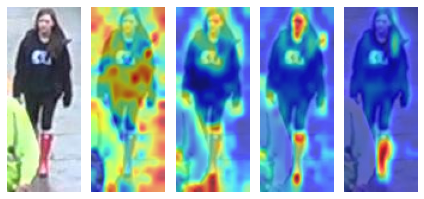

Mean Side Attention


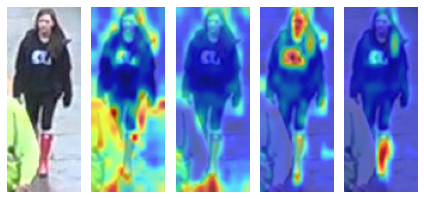

Mean Self Attention


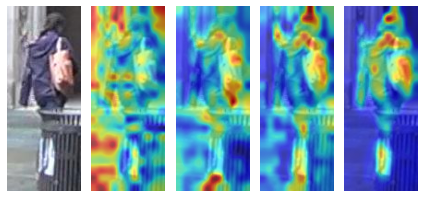

Mean Side Attention


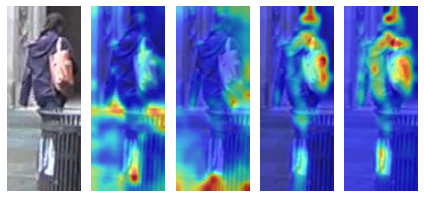

Mean Self Attention


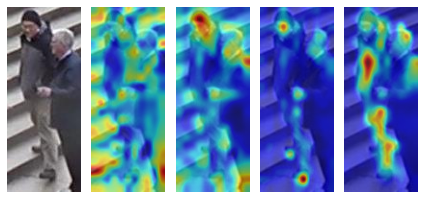

Mean Side Attention


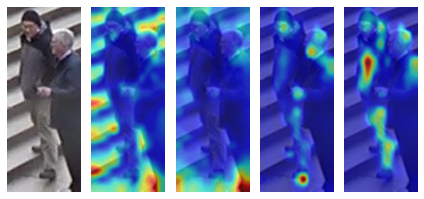

Mean Self Attention


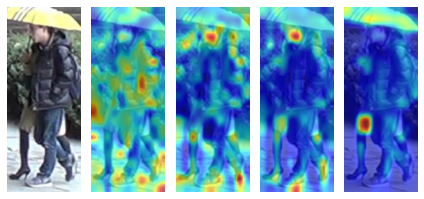

Mean Side Attention


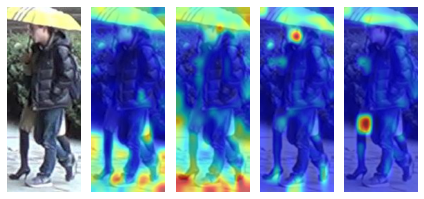

In [11]:
config_file = "configs/OCC_Duke/vit_tat_stride.yml"
weight = "/home/zhaozr/code/logs/occ_duke_vit_tat_stride/transformer_120.pth"
model = get_model(config_file, weight)

images = [("../../data/Occluded_Duke/query/0180_c1_f0086233.jpg", 1),
          ("../../data/Occluded_Duke/query/0274_c1_f0098056.jpg", 1),
          ("../../data/Occluded_Duke/query/0367_c3_f0083393.jpg", 3),
          ("../../data/Occluded_Duke/query/0415_c6_f0104535.jpg", 6),
          ("../../data/Occluded_Duke/query/0580_c4_f0133960.jpg", 4),
          ("../../data/Occluded_Duke/query/1228_c4_f0185789.jpg", 4),
          ("../../data/Occluded_Duke/query/2479_c7_f0073880.jpg", 7),
          ("../../data/Occluded_Duke/bounding_box_test/6725_c8_f0151667.jpg", 8),
        #   ("../../data/Occluded_Duke/bounding_box_test/0279_c2_f0098460.jpg", 2),
          ("../../data/Occluded_Duke/bounding_box_test/0652_c3_f0147073.jpg", 3),
]

for (path, cam) in images:
    img, att = inference(path, model, transform256, camlabel=cam)
    let_me_see_see(img, att, grid_size=(22, 11), layers=[1, 3, 6, 10])

##### Person 1

In [ ]:
img = Image.open("../../data/Occluded_Duke/query/0251_c4_f0066205.jpg")
out, att_mat = model(transform256(img).unsqueeze(0), cam_label=[3], get_attn_weights=True)
att_mat = [a.detach().cpu().numpy() for a in att_mat]
for layer in range(len(att_mat)):
    visualize_grid_to_grid_mean_with_template(att_mat[layer][0].mean(axis=0), img, grid_size=(22, 11))

##### Person 2

In [ ]:
img = Image.open("../../data/Occluded_Duke/bounding_box_test/6725_c8_f0151667.jpg")
out, att_mat = model(transform256(img).unsqueeze(0), cam_label=[7], get_attn_weights=True)
att_mat = [a.detach().cpu().numpy() for a in att_mat]
for layer in range(len(att_mat)):
    visualize_grid_to_grid_mean_with_template(att_mat[layer][0].mean(axis=0), img, grid_size=(22, 11))

### Visualize Attention Map

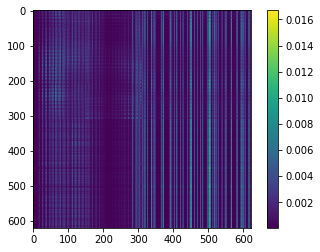

In [65]:
visualize_head(att_mat[10][0,3])

#### Attention maps in layer 1~3

First, the attention from the front layers mostly focuses on itself, performing true self-attention to understand its own information. For example, this is the attention map of all heads in the first layer, characterized by a clear **diagonal pattern**.

In [ ]:
visualize_heads(att_mat[0], cols=6)

In [ ]:
visualize_heads(att_mat[1], cols=6)

In [ ]:
visualize_heads(att_mat[2], cols=6)

#### Attention maps in layer 4~7

Then, the model gradually increases its receptive field, integrating surrounding information and showing **multiple diagonal patterns**.

In [ ]:
visualize_heads(att_mat[3], cols=6)

In [ ]:
visualize_heads(att_mat[4], cols=6)

In [ ]:
visualize_heads(att_mat[5], cols=6)

In [ ]:
visualize_heads(att_mat[6], cols=6)

#### Attention maps in layer 8~11

Finally, important information aggregates onto specific tokens, and attention appears to be independent of the query, displaying a **vertical pattern** on the attention map.

In [ ]:
visualize_heads(att_mat[7], cols=6)

In [ ]:
visualize_heads(att_mat[8], cols=6)

In [ ]:
visualize_heads(att_mat[9], cols=6)

In [ ]:
visualize_heads(att_mat[10], cols=6)